In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Useful methods

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
1. Apply a distortion correction to raw images.
1. Use color transforms, gradients, etc., to create a thresholded binary image.
1. Apply a perspective transform to rectify binary image ("birds-eye view").
1. Detect lane pixels and fit to find the lane boundary.
1. Determine the curvature of the lane and vehicle position with respect to center.
1. Warp the detected lane boundaries back onto the original image.
1. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

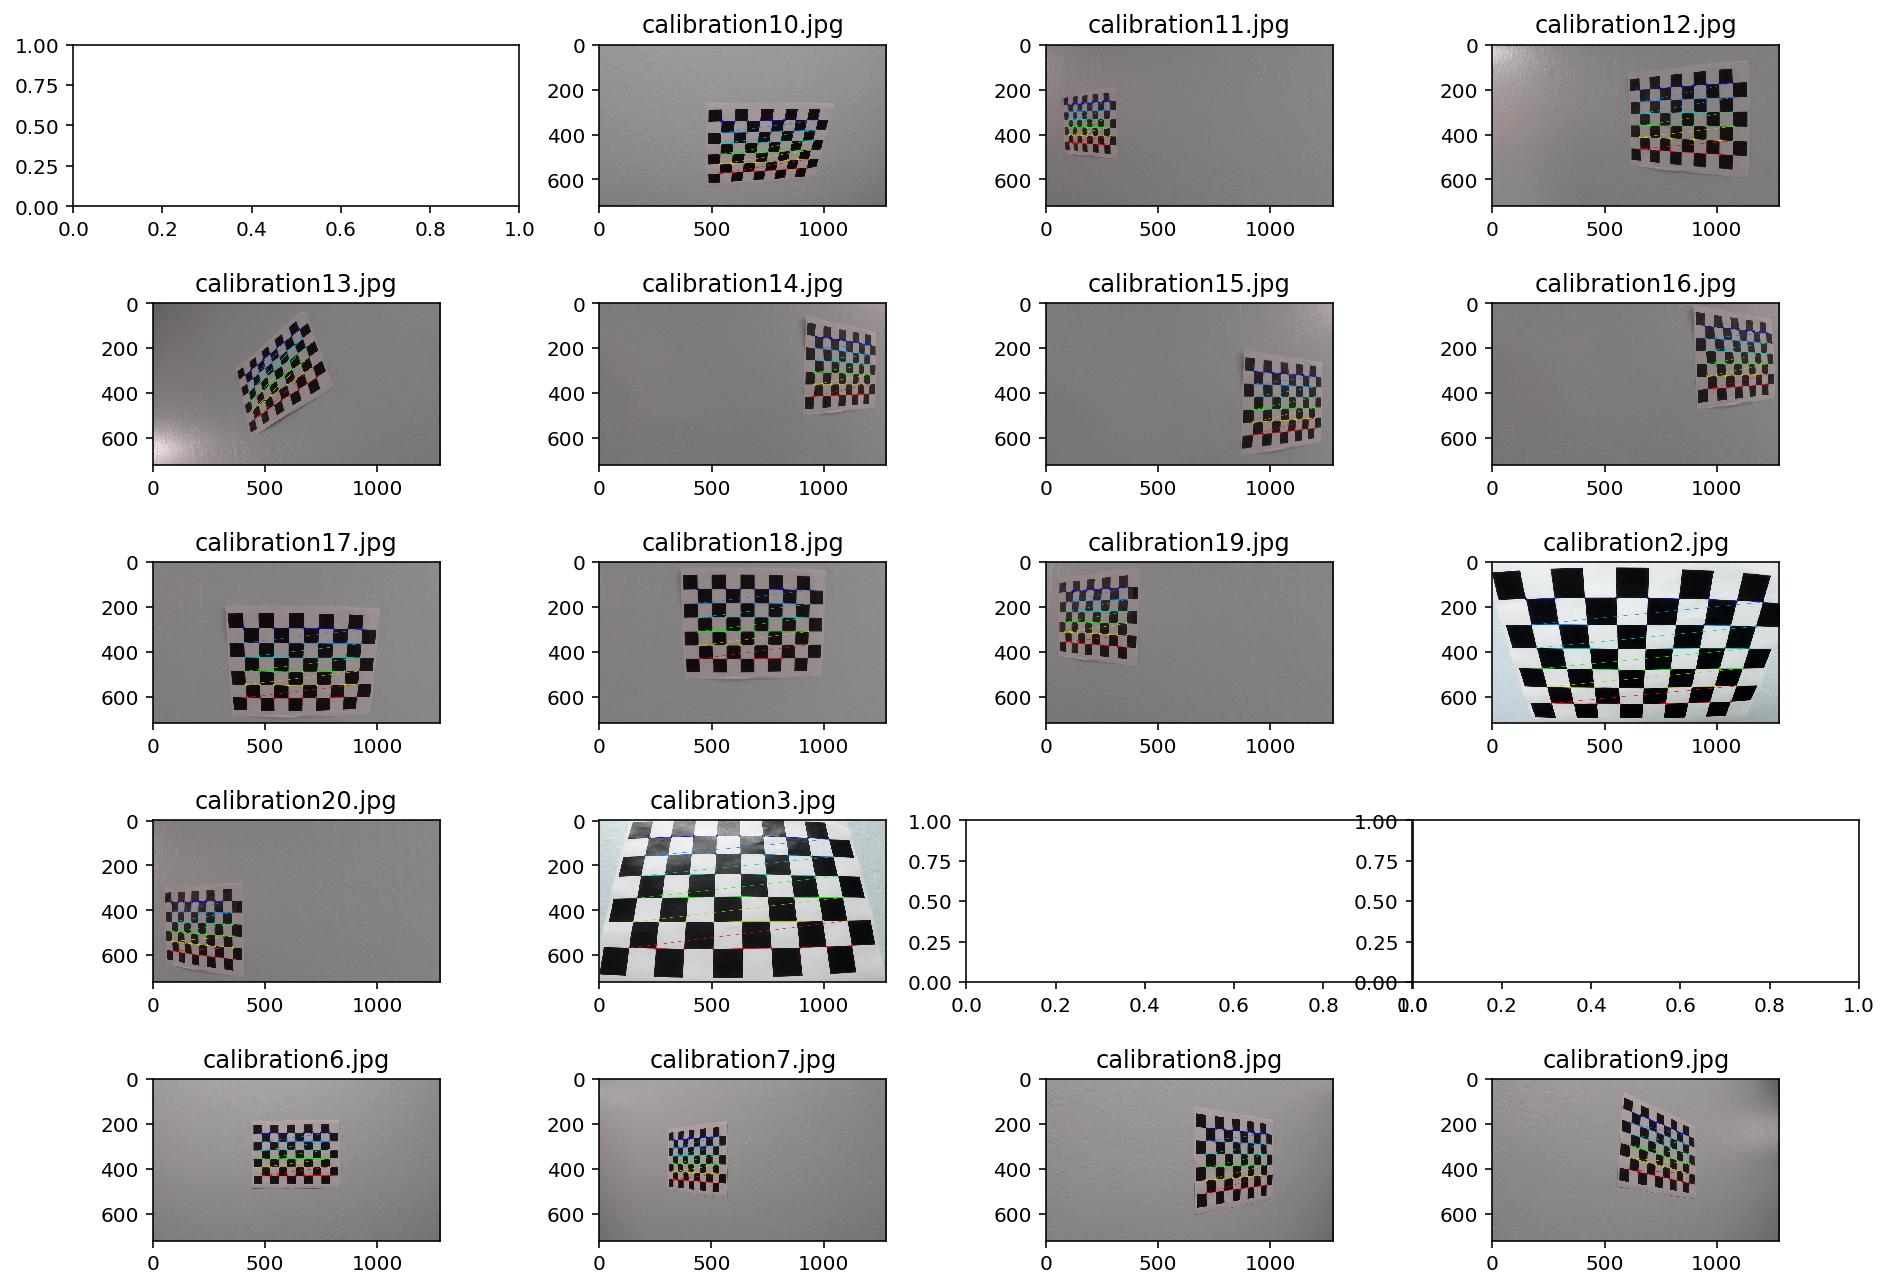

In [2]:
# cal_files = sorted(os.listdir(dir_name))
corner_size = (9,6)
nx, ny = corner_size
fail_list = []

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .6, wspace=.001)
axs = axs.ravel()

# Directory
dir_name = "camera_cal/"
images = sorted(os.listdir(dir_name))

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for i, fname in enumerate(images):
    img = cv2.imread(os.path.join(dir_name, fname))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners2, ret)
        axs[i].imshow(img)
        axs[i].set_title(fname)
plt.show()

## Perspective Transform

In [3]:
height, width = 720, 1280

src = np.float32([[225, 705], [550, 482], [732, 482], [1050, 705]])
margin = 400
dst = np.float32([[width/2 - margin, height], 
                  [width/2 - margin, 0],
                  [width/2 + margin, 0], 
                  [width/2 + margin, height]])

straight_lines1.jpg


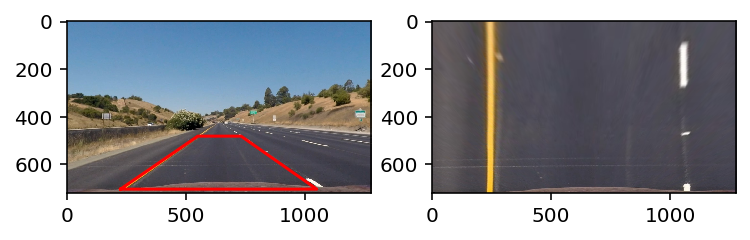

straight_lines2.jpg


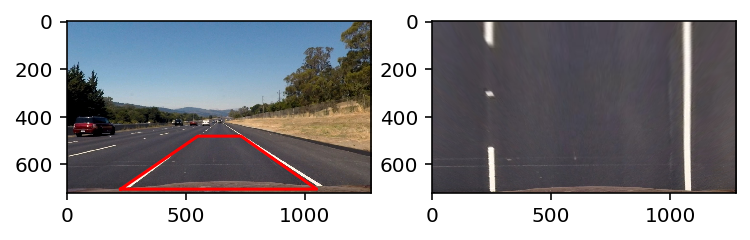

test1.jpg


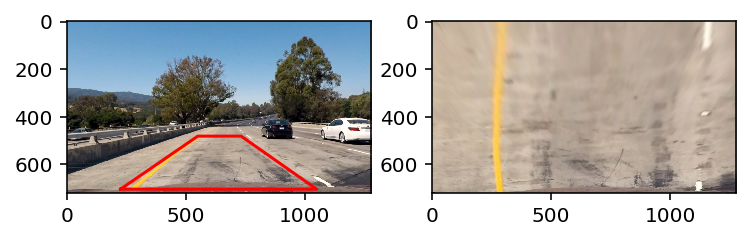

test2.jpg


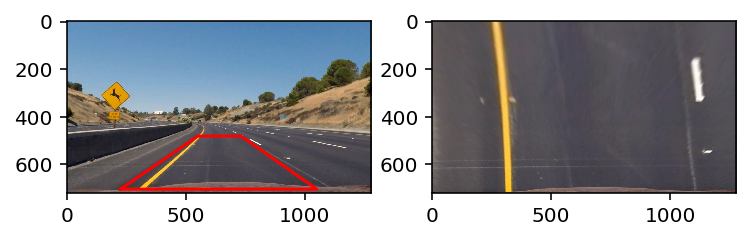

test3.jpg


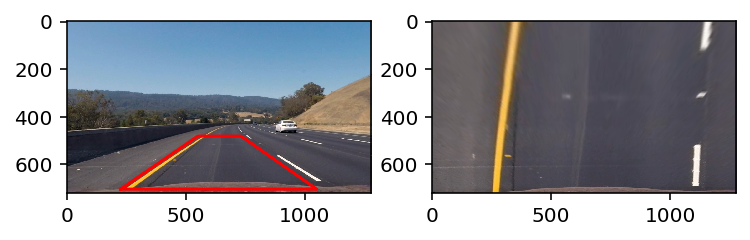

test4.jpg


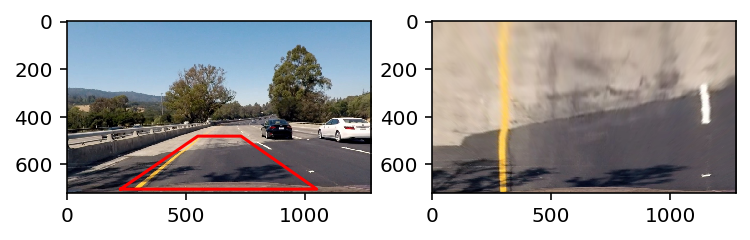

test5.jpg


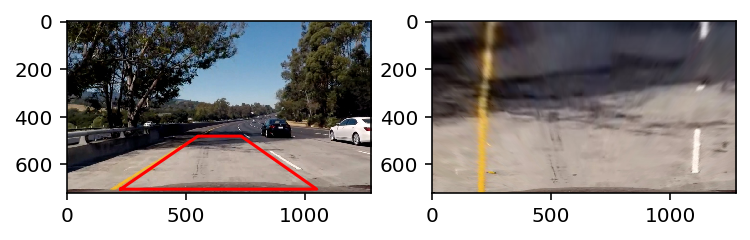

test6.jpg


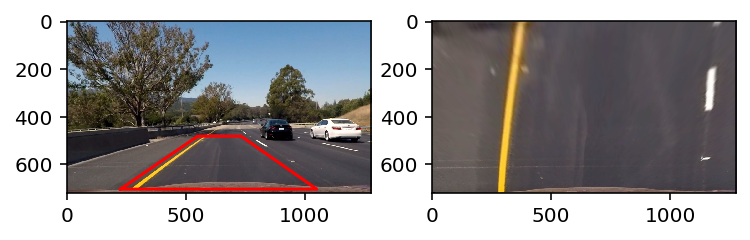

In [4]:
test_files = sorted(os.listdir("test_images/"))
# image_path = test_files[0]
for image_path in test_files:
    print(image_path)
    image = mpimg.imread('test_images/{}'.format(image_path))
    img_size = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)

    plt.clf()
    plt.subplot(1, 2, 1)
    plt.imshow(undist)
    plt.plot(src[[0, 1, 2, 3, 0], 0], src[[0, 1, 2, 3, 0], 1], 'r-')
    M = cv2.getPerspectiveTransform(src, dst)
    invM = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

    plt.subplot(1, 2, 2)
    plt.imshow(warped)
    plt.show()

## Thresholding

In [5]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fitx, right_fitx, ploty

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

def search_around_poly(binary_warped, left_fit, right_fit, margin=100):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) +
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) +
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

def fit_polynomial(binary_warped, previous_lanes=None):
    # Find our lane pixels first
    if previous_lanes is None:
        leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)
    else:
        left_fit, right_fit = previous_lanes
        leftx, lefty, rightx, righty = search_around_poly(binary_warped, left_fit, right_fit)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = None
        right_fitx = None

    return left_fitx, ploty, right_fitx, ploty, left_fit, right_fit

In [6]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [7]:
from collections import deque
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen=10)
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = 10000
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')

    def add_detected_lane(self, fit_x, fity):
        old_fit = self.current_fit.copy()
        self.diffs = np.abs(old_fit - fit_x)
        # set current fit coeff
        self.current_fit = fit_x

        # add xvalues of the last n fits
        if (fit_x is not None) and self.radius_of_curvature > 150:
            self.recent_xfitted.append(fit_x)
            # average recent n fits
            self.best_fit = np.mean(self.recent_xfitted, 0)
            self.best_x = self.best_fit[0]*fity**2 + self.best_fit[1]*fity + self.best_fit[2]
            self.detected = True
        else:
            self.detected = False

In [8]:
def camera_calibration(img, objpoints, imgpoints, img_size):
    # Camera calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def perspective_transform(img, src, dst, img_size):
    # Perspective Transform
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

def thresholding(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # HLS image
    img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = img_hls[:,:,1]
    s_channel = img_hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

def compute_curvature(fit_cr, fity, xm_per_pix, ym_per_pix):
    fitx = fit_cr[0]*fity**2 + fit_cr[1]*fity + fit_cr[2]
    fit_cr = np.polyfit(fity*ym_per_pix, fitx*xm_per_pix, 2)
    y_eval = np.max(fity)
    radius_curvature = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return radius_curvature

def draw_lanes_information(undist, left_fit_x, right_fit_x, ploty, Minv, left_curverad, right_curverad):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(undist).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fit_x, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    center = width/2 - (right_lane.best_x[0] + left_lane.best_x[0]) / 2
    left_right = 'left' if center < 0 else 'left'
    text_string = "Vihicle is {} of center {:2.2f}m".format(left_right, np.abs(center * xm_per_pix))
    result = cv2.putText(result, text_string, (50, 50), cv2.FONT_HERSHEY_SIMPLEX,  
                   1.5, (255, 255, 255), 2, cv2.LINE_AA) 
    text_string = "Radius of Curvature: (L: {:4.0f}m, R: {:4.0f}m)".format(left_curverad, right_curverad)
    result = cv2.putText(result, text_string, (50, 100), cv2.FONT_HERSHEY_SIMPLEX,  
                   1.5, (255, 255, 255), 2, cv2.LINE_AA)
    return result

In [9]:
left_lane = Line()
right_lane = Line()

def pipeline(image, xm_per_pix = 3.7/700, ym_per_pix = 30/720):
    img_size = (image.shape[1], image.shape[0])

    # Camera Calibration
    undist = camera_calibration(image, objpoints, imgpoints, img_size)

    # Perspective Transform
    warped, M, Minv = perspective_transform(undist, src, dst, img_size)

    # Thresholding
    combined_binary = thresholding(warped)

    
    if left_lane.detected and right_lane.detected:
        previous_lanes = (left_lane.best_fit, right_lane.best_fit)
    else:
        previous_lanes = None

    # Finding lanes and Polinomial fitting
    _, _, _, ploty, left_fit_cr, right_fit_cr= fit_polynomial(combined_binary, previous_lanes=previous_lanes)

    left_lane.add_detected_lane(left_fit_cr, ploty)
    right_lane.add_detected_lane(right_fit_cr, ploty)

    left_fit_cr = left_lane.best_fit
    right_fit_cr = right_lane.best_fit
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = compute_curvature(left_fit_cr, ploty, xm_per_pix, ym_per_pix)
    right_curverad = compute_curvature(right_fit_cr, ploty, xm_per_pix, ym_per_pix)
    
    left_lane.radius_of_curvature = left_curverad
    right_lane.radius_of_curvature = right_curverad
    
    # Draw information on an image
    result = draw_lanes_information(undist, left_lane.best_x, right_lane.best_x, ploty, Minv, 
                                    left_curverad, right_curverad)

    return result

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 27min 7s, sys: 26.1 s, total: 27min 33s
Wall time: 15min 18s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [13]:
left_lane = Line()
right_lane = Line()

white_output = 'challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video challenge_video_output.mp4.
Moviepy - Writing video challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready challenge_video_output.mp4
CPU times: user 10min 32s, sys: 11 s, total: 10min 43s
Wall time: 6min 5s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))